In [1]:
import numpy as np
import os
import pandas as pd
import tarfile
from src.file_ops import npy_loader, get_probe_signals
from dataclasses import dataclass
from typing import Optional
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
# Set the current working directory
cwd = os.chdir(r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz")

# @title Data retrieval
data_directory = r'data\spikeAndBehavioralData'

session_label_string = "Cori_2016-12-14"

session_label = session_label_string.split("_")
print(session_label)

# test_dataset
test_LFP = session_label_string

['Cori', '2016-12-14']


In [3]:
walker = os.walk(os.path.join(os.getcwd(),data_directory))
for root, dirs, files in walker:
    print(root)
    print(dirs)
    for file in files:
        print(file)


C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData
[]
Cori_2016-12-14.tar
Cori_2016-12-17.tar
Cori_2016-12-18.tar
Forssmann_2017-11-01.tar
Forssmann_2017-11-02.tar
Forssmann_2017-11-04.tar
Forssmann_2017-11-05.tar
Hench_2017-06-15.tar
Hench_2017-06-16.tar
Hench_2017-06-17.tar
Hench_2017-06-18.tar
Lederberg_2017-12-05.tar
Lederberg_2017-12-06.tar
Lederberg_2017-12-07.tar
Lederberg_2017-12-08.tar
Lederberg_2017-12-09.tar
Lederberg_2017-12-10.tar
Lederberg_2017-12-11.tar
Moniz_2017-05-15.tar
Moniz_2017-05-16.tar
Moniz_2017-05-18.tar
Muller_2017-01-07.tar
Muller_2017-01-08.tar
Muller_2017-01-09.tar
Radnitz_2017-01-08.tar
Radnitz_2017-01-09.tar
Radnitz_2017-01-10.tar
Radnitz_2017-01-11.tar
Radnitz_2017-01-12.tar
Richards_2017-10-29.tar
Richards_2017-10-30.tar
Richards_2017-10-31.tar
Richards_2017-11-01.tar
Richards_2017-11-02.tar
Tatum_2017-12-06.tar
Tatum_2017-12-07.tar
Tatum_2017-12-08.tar
Tatum_2017-12-09.tar
Theiler_2017-10-11.tar


In [4]:
# def extract_spikes_data(filename):
#     with tarfile.open(filename) as tar:
#         spikes = [name for name in tar.getnames() if name.startswith('spikes')]

In [5]:
@dataclass
class Clusters:
    depths: Optional[np.ndarray] = None
    original_ids: Optional[np.ndarray] = None
    site: Optional[np.ndarray] = None
    probes: Optional[np.ndarray] = None
    template_waveform_chans: Optional[np.ndarray] = None
    template_waveforms: Optional[np.ndarray] = None
    waveform_duration: Optional[np.ndarray] = None
    phy_annotation: Optional[np.ndarray] = None

    def __post_init__(self):
        """Ensure specific fields are integers"""
        if self.original_ids is not None:
            self.original_ids = self.original_ids.astype(int)
        if self.site is not None:
            self.site = self.site.astype(int)
        if self.probes is not None:
            self.probes = self.probes.astype(int)

    def to_dataframe(self) -> pd.DataFrame:
        """
        Convert the cluster data to a pandas DataFrame.
        For multi-dimensional arrays, only the first dimension is used as the index,
        and the remaining dimensions are stored as array objects in the cells.
        """
        data_dict = {}
        base_length = None

        # Process each attribute
        for attr_name, value in self.__dict__.items():
            if value is not None:
                if len(value.shape) == 1:
                    # 1D arrays can be directly added
                    data_dict[attr_name] = value
                    if base_length is None:
                        base_length = len(value)
                else:
                    # For multi-dimensional arrays, store them as objects
                    # Each row will contain a slice of the array
                    data_dict[attr_name] = [value[i] for i in range(value.shape[0])]
                    if base_length is None:
                        base_length = value.shape[0]

        # Create DataFrame
        df = pd.DataFrame(data_dict)

        df[['original_ids','site','probes','phy_annotation']] = df[['original_ids','site','probes','phy_annotation']].astype(int)

        return df

    @classmethod
    def from_tar(cls, tar_path: str | Path) -> 'Clusters':
        """
        Load cluster data from a tar file containing numpy arrays.

        Args:
            tar_path: Path to the tar file containing cluster data

        Returns:
            ClusterData instance with loaded arrays

        Raises:
            FileNotFoundError: If tar file doesn't exist
            ValueError: If expected cluster files are missing
        """
        # if not os.path.exists(tar_path):
        #     raise FileNotFoundError(f"Tar file not found: {tar_path}")

        data = cls()

        with tarfile.open(tar_path, 'r') as tar:
            cluster_files = [name for name in tar.getnames() if name.startswith('clusters')]

            # Mapping between file names and dataclass attributes
            file_attr_map = {
                'clusters.depths.npy': 'depths',
                'clusters.originalIDs.npy': 'original_ids',
                'clusters.peakChannel.npy': 'site',
                'clusters.probes.npy': 'probes',
                'clusters.templateWaveformChans.npy': 'template_waveform_chans',
                'clusters.templateWaveforms.npy': 'template_waveforms',
                'clusters.waveformDuration.npy': 'waveform_duration',
                'clusters._phy_annotation.npy': 'phy_annotation'
            }

            # Extract and load each file
            for file_name, attr_name in file_attr_map.items():
                if file_name not in cluster_files:
                    print(f"Warning: {file_name} not found in tar archive")
                    continue

                # try:
                #     # Extract file to memory and load with numpy
                #     member = tar.extractfile(file_name)
                #     if member is None:
                #         raise ValueError(f"Could not extract {file_name}")
                array_data = np.squeeze(npy_loader(tar,file_name))
                setattr(data, attr_name, array_data)

                # except Exception as e:
                #     print(f"Error loading {file_name}: {str(e)}")
            data.site =  data.template_waveform_chans[:,0]

        return data

@dataclass
class Trials:
    feedback_type: Optional[np.ndarray] = None
    feedback_times: Optional[np.ndarray] = None
    gocue_times: Optional[np.ndarray] = None
    included: Optional[np.ndarray] = None
    intervals: Optional[np.ndarray] = None
    repNum: Optional[np.ndarray] = None
    response_choice: Optional[np.ndarray] = None
    response_times: Optional[np.ndarray] = None
    contrast_left: Optional[np.ndarray] = None
    constra_right: Optional[np.ndarray] = None
    stimulus_times: Optional[np.ndarray] = None


    def to_dataframe(self) -> pd.DataFrame:
        """
        Convert the Trials data to a pandas DataFrame.
        For multi-dimensional arrays, only the first dimension is used as the index,
        and the remaining dimensions are stored as array objects in the cells.
        """
        data_dict = {}
        base_length = None

        # Process each attribute
        for attr_name, value in self.__dict__.items():
            if value is not None:
                if len(value.shape) == 1:
                    # 1D arrays can be directly added
                    data_dict[attr_name] = value
                    if base_length is None:
                        base_length = len(value)
                else:
                    # For multi-dimensional arrays, store them as objects
                    # Each row will contain a slice of the array
                    data_dict[attr_name] = [value[i] for i in range(value.shape[0])]
                    if base_length is None:
                        base_length = value.shape[0]

        # Create DataFrame
        df = pd.DataFrame(data_dict)
        return df

    @classmethod
    def from_tar(cls, tar_path: str | Path) -> 'Trials':
        """
        Load cluster data from a tar file containing numpy arrays.

        Args:
            tar_path: Path to the tar file containing cluster data

        Returns:
            ClusterData instance with loaded arrays

        Raises:
            FileNotFoundError: If tar file doesn't exist
            ValueError: If expected cluster files are missing
        """
        # if not os.path.exists(tar_path):
        #     raise FileNotFoundError(f"Tar file not found: {tar_path}")

        data = cls()

        with tarfile.open(tar_path, 'r') as tar:
            trial_files = [name for name in tar.getnames() if name.startswith('trials')]

            # Mapping between file names and dataclass attributes
            file_attr_map = {
                'trials.feedbackType.npy': 'feedback_type',
                'trials.feedback_times.npy': 'feedback_times',
                'trials.goCue_times.npy': 'gocue_times',
                'trials.included.npy': 'included',
                'trials.intervals.npy': 'intervals',
                'trials.repNum.npy': 'repNum',
                'trials.response_choice.npy': 'response_choice',
                'trials.response_times.npy': 'response_times',
                'trials.visualStim_contrastLeft.npy': 'contrast_left',
                'trials.visualStim_contrastRight.npy': 'contrast_right',
                'trials.visualStim_times.npy': 'stimulus_times',
            }

            # Extract and load each file
            for file_name, attr_name in file_attr_map.items():
                if file_name not in trial_files:
                    print(f"Warning: {file_name} not found in tar archive")
                    continue

                # try:
                #     # Extract file to memory and load with numpy
                #     member = tar.extractfile(file_name)
                #     if member is None:
                #         raise ValueError(f"Could not extract {file_name}")

                array_data = np.squeeze(npy_loader(tar,file_name))
                setattr(data, attr_name, array_data)

                # except Exception as e:
                #     print(f"Error loading {file_name}: {str(e)}")
        return data

@dataclass
class Spikes:
    amps: Optional[np.ndarray] = None
    clusters: Optional[np.ndarray] = None
    depths: Optional[np.ndarray] = None
    times: Optional[np.ndarray] = None

    def to_dataframe(self) -> pd.DataFrame:
        """
        Convert the Trials data to a pandas DataFrame.
        For multi-dimensional arrays, only the first dimension is used as the index,
        and the remaining dimensions are stored as array objects in the cells.
        """
        data_dict = {}
        base_length = None

        # Process each attribute
        for attr_name, value in self.__dict__.items():
            if value is not None:
                if len(value.shape) == 1:
                    # 1D arrays can be directly added
                    data_dict[attr_name] = value
                    if base_length is None:
                        base_length = len(value)
                else:
                    # For multi-dimensional arrays, store them as objects
                    # Each row will contain a slice of the array
                    data_dict[attr_name] = [value[i] for i in range(value.shape[0])]
                    if base_length is None:
                        base_length = value.shape[0]

        # Create DataFrame
        df = pd.DataFrame(data_dict)
        df['clusters'] = df['clusters'].astype(int)
        return df

    @classmethod
    def from_tar(cls, tar_path: str | Path) -> 'Spikes':
        """
        Load cluster data from a tar file containing numpy arrays.

        Args:
            tar_path: Path to the tar file containing cluster data

        Returns:
            ClusterData instance with loaded arrays

        Raises:
            FileNotFoundError: If tar file doesn't exist
            ValueError: If expected cluster files are missing
        """
        # if not os.path.exists(tar_path):
        #     raise FileNotFoundError(f"Tar file not found: {tar_path}")

        data = cls()

        with tarfile.open(tar_path, 'r') as tar:
            trial_files = [name for name in tar.getnames() if name.startswith('spikes')]

            # Mapping between file names and dataclass attributes
            file_attr_map = {
                'spikes.amps.npy': 'amps',
                'spikes.clusters.npy': 'clusters',
                'spikes.depths.npy': 'depths',
                'spikes.times.npy': 'times',
            }

            # Extract and load each file
            for file_name, attr_name in file_attr_map.items():
                if file_name not in trial_files:
                    print(f"Warning: {file_name} not found in tar archive")
                    continue

                # try:
                #     # Extract file to memory and load with numpy
                #     member = tar.extractfile(file_name)
                #     if member is None:
                #         raise ValueError(f"Could not extract {file_name}")

                array_data = np.squeeze(npy_loader(tar,file_name))
                setattr(data, attr_name, array_data)

                # except Exception as e:
                #     print(f"Error loading {file_name}: {str(e)}")

        return data

@dataclass
class BrainLocation:
    """Dataclass for brain location information from channels.brainLocation.tsv"""
    ap: np.ndarray  # AP position in CCF [µm]
    dv: np.ndarray  # DV position in CCF [µm]
    lr: np.ndarray  # LR position in CCF [µm]
    allen_ontology: np.ndarray  # Brain region acronyms

    @classmethod
    def from_tsv(cls, tsv_file) -> 'BrainLocation':
        """Load brain location data from a TSV file or file-like object"""
        df = pd.read_csv(tsv_file, sep='\t')
        return cls(
            ap=df['ccf_ap'].to_numpy(),
            dv=df['ccf_dv'].to_numpy(),
            lr=df['ccf_lr'].to_numpy(),
            allen_ontology=df['allen_ontology'].to_numpy()
        )

@dataclass
class Channels:
    """Main dataclass for channel-related data"""
    brain_location: Optional[BrainLocation] = None
    probes: Optional[np.ndarray] = None  # [integer] (nChannels)
    raw_row: Optional[np.ndarray] = None  # [integer] (nChannels)
    site: Optional[np.ndarray] = None  # [integer] (nChannels)
    site_positions: Optional[np.ndarray] = None  # [µm] (nChannels, 2)

    @classmethod
    def from_tar(cls, tar_path: str | Path) -> 'ChannelData':
        """
        Load channel data from a tar file containing the channel-related files.

        Args:
            tar_path: Path to the tar file containing channel data

        Returns:
            ChannelData instance with loaded arrays

        Raises:
            FileNotFoundError: If tar file doesn't exist
            ValueError: If expected channel files are missing
        """
        if not os.path.exists(tar_path):
            raise FileNotFoundError(f"Tar file not found: {tar_path}")

        data = cls()

        with tarfile.open(tar_path, 'r') as tar:
            channel_files = [name for name in tar.getnames() if name.startswith('channels')]

            # Load brain location TSV file
            if 'channels.brainLocation.tsv' in channel_files:
                member = tar.extractfile('channels.brainLocation.tsv')
                if member is not None:
                    data.brain_location = BrainLocation.from_tsv(member)

            # Mapping between NPY files and dataclass attributes
            npy_file_map = {
                'channels.probe.npy': 'probes',
                'channels.rawRow.npy': 'raw_row',
                'channels.site.npy': 'site',
                'channels.sitePositions.npy': 'site_positions'
            }

            # Load NPY files
            for file_name, attr_name in npy_file_map.items():
                if file_name in channel_files:
                    try:
                        member = tar.extractfile(file_name)
                        if member is None:
                            raise ValueError(f"Could not extract {file_name}")

                        array_data = np.squeeze(npy_loader(tar,file_name))
                        setattr(data, attr_name, array_data)

                    except Exception as e:
                        print(f"Error loading {file_name}: {str(e)}")
                else:
                    print(f"Warning: {file_name} not found in tar archive")

        return data

    def to_dataframe(self) -> pd.DataFrame:
        """
        Convert channel data to a pandas DataFrame.
        For multi-dimensional arrays (like site_positions), stores them as array objects.
        """
        data_dict = {}

        # Add brain location data if available
        if self.brain_location is not None:
            data_dict.update({
                'ap': self.brain_location.ap,
                'dv': self.brain_location.dv,
                'lr': self.brain_location.lr,
                'allen_ontology': self.brain_location.allen_ontology
            })

        # Add other channel data
        if self.probes is not None:
            data_dict['probes'] = self.probes.astype(np.int32)
        if self.raw_row is not None:
            data_dict['raw_row'] = self.raw_row.astype(np.int32)
        if self.site is not None:
            data_dict['site'] = self.site.astype(np.int32)
        if self.site_positions is not None:
            # Store 2D site positions as array objects
            data_dict['site_positions'] = [pos for pos in self.site_positions]

        return pd.DataFrame(data_dict)

In [6]:
alldata_tar_path = os.path.join(os.getcwd(),data_directory,test_LFP + r".tar")
print(alldata_tar_path)
with tarfile.open(alldata_tar_path, 'r') as tar:
    print(type(tar))
    # print(tar.getnames())

    clusters = [name for name in tar.getnames() if name.startswith('clusters')]
    spikes = [name for name in tar.getnames() if name.startswith('spikes')]
    trials = [name for name in tar.getnames() if name.startswith('trials')]
    print(clusters)
    print(spikes)
    print(trials)
    wheel = [name for name in tar.getnames() if name.startswith('wheel')]
    print(wheel)
    wheel_pos = npy_loader(tar,wheel[0])
    wheel_time = npy_loader(tar,wheel[1])
    wheel_move_intervals = npy_loader(tar,wheel[2])
    wheel_move_type = npy_loader(tar,wheel[3])
    # wheel_timestamps = npy_loader(tar,wheel[1])
    # for spike in spikes:
    #     print(npy_loader(tar,spike).shape)
    #
    # for cluster in clusters:
    #     print(npy_loader(tar,cluster).shape)
    #
    # for trial in trials:
    #     print(npy_loader(tar,trial).shape)

cluster_data = Clusters.from_tar(alldata_tar_path)
trials = Trials.from_tar(alldata_tar_path)
spike_data = Spikes.from_tar(alldata_tar_path)
channel_data = Channels.from_tar(alldata_tar_path)

C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData\Cori_2016-12-14.tar
<class 'tarfile.TarFile'>
['clusters.depths.npy', 'clusters.originalIDs.npy', 'clusters.peakChannel.npy', 'clusters.probes.npy', 'clusters.templateWaveformChans.npy', 'clusters.templateWaveforms.npy', 'clusters.waveformDuration.npy', 'clusters._phy_annotation.npy']
['spikes.amps.npy', 'spikes.clusters.npy', 'spikes.depths.npy', 'spikes.times.npy']
['trials.feedbackType.npy', 'trials.feedback_times.npy', 'trials.goCue_times.npy', 'trials.included.npy', 'trials.intervals.npy', 'trials.repNum.npy', 'trials.response_choice.npy', 'trials.response_times.npy', 'trials.visualStim_contrastLeft.npy', 'trials.visualStim_contrastRight.npy', 'trials.visualStim_times.npy']
['wheel.position.npy', 'wheel.timestamps.npy', 'wheelMoves.intervals.npy', 'wheelMoves.type.npy']


In [7]:
print(wheel_time.shape)
print(wheel_time[1,0])
time_series = np.linspace(wheel_time[0,1],wheel_time[1,1],int(wheel_time[1,0]+1))
print(time_series.shape)
print(wheel_pos.shape)
print(wheel_move_intervals.shape)
print(wheel_move_type.shape)

(2, 2)
6569999.0
(6570000,)
(6570000, 1)
(507, 2)
(507, 1)


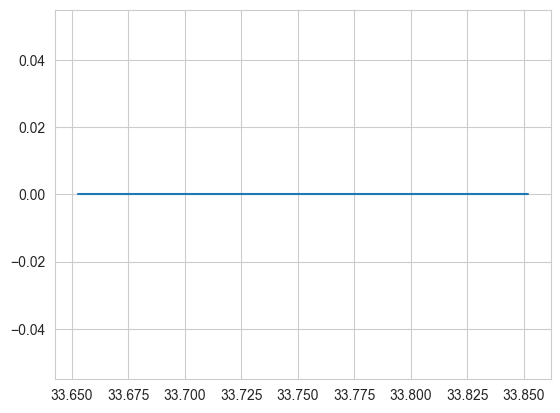

In [8]:
plt.plot(time_series[:500], wheel_pos[:500])

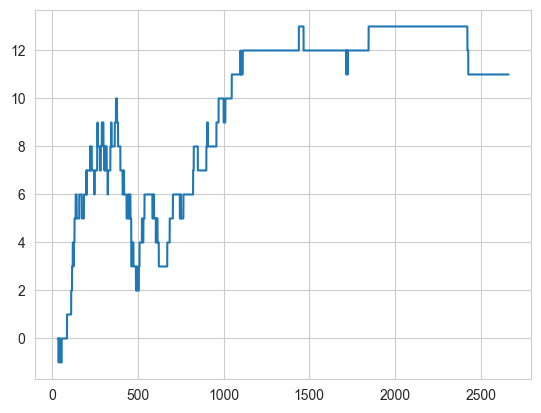

In [9]:
plt.plot(time_series, wheel_pos//1440)

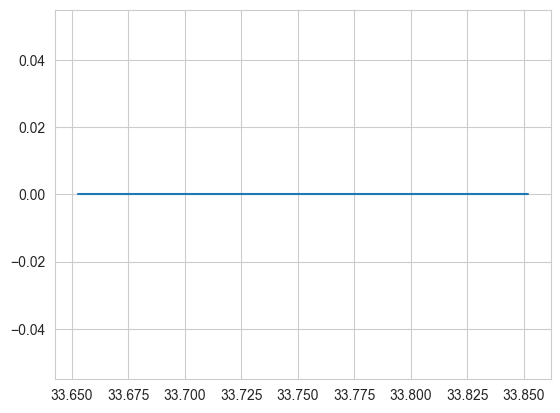

In [10]:
plt.plot(time_series[:500], wheel_pos[:500] % 1440)

In [11]:
wheel_data =pd.DataFrame()
wheel_data['time'] = time_series
wheel_data['ticks'] = wheel_pos
wheel_data['revolution'] = wheel_pos//1440
wheel_data['angle'] = np.deg2rad(((wheel_pos % 1440)/1440)*360)/np.pi


In [12]:
wheel_data.head(500)

,time,ticks,revolution,angle
0,33.652504,0.0,0.0,0.0
1,33.652904,0.0,0.0,0.0
2,33.653304,0.0,0.0,0.0
3,33.653704,0.0,0.0,0.0
4,33.654104,0.0,0.0,0.0
...,...,...,...,...
495,33.850507,0.0,0.0,0.0
496,33.850907,0.0,0.0,0.0
497,33.851307,0.0,0.0,0.0
498,33.851707,0.0,0.0,0.0


In [13]:
cluster_df = cluster_data.to_dataframe()
print(cluster_df.shape)
cluster_df = cluster_df.query('phy_annotation != 0')
cluster_df.phy_annotation.value_counts()

(1085, 8)


phy_annotation
3    729
1    351
2      5
Name: count, dtype: int64

In [14]:
cluster_df[['mouse_name', 'date_exp']] = session_label
cluster_df.head()

,depths,original_ids,site,probes,template_waveform_chans,template_waveforms,waveform_duration,phy_annotation,mouse_name,date_exp
0,2297.232386,0,223,0,"[223.0, 225.0, 222.0, 220.0, 227.0, 219.0, 221...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",19.0,3,Cori,2016-12-14
1,3240.539945,1,315,0,"[315.0, 317.0, 313.0, 316.0, 312.0, 314.0, 311...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",19.0,3,Cori,2016-12-14
2,1744.355208,3,171,0,"[171.0, 169.0, 168.0, 167.0, 170.0, 173.0, 166...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",10.0,3,Cori,2016-12-14
3,265.098545,4,27,0,"[27.0, 24.0, 25.0, 26.0, 23.0, 22.0, 28.0, 29....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17.0,3,Cori,2016-12-14
4,328.853292,7,33,0,"[33.0, 31.0, 29.0, 32.0, 35.0, 28.0, 30.0, 27....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16.0,1,Cori,2016-12-14


In [15]:
trial_df = trials.to_dataframe()
trial_df[['mouse_name', 'date_exp']] = session_label
trial_df.head()

,feedback_type,feedback_times,gocue_times,included,intervals,repNum,response_choice,response_times,contrast_left,stimulus_times,contrast_right,mouse_name,date_exp
0,1.0,66.456227,66.296625,True,"[62.90028371085413, 67.42348445160172]",1.0,1.0,66.419612,1.0,65.269408,0.0,Cori,2016-12-14
1,1.0,72.640326,72.077117,True,"[68.42083771830875, 73.60447564732587]",1.0,-1.0,72.602206,0.0,71.202703,0.5,Cori,2016-12-14
2,1.0,77.038396,76.877593,True,"[74.60290237095717, 78.00675700882503]",1.0,1.0,77.001671,1.0,76.052380,0.5,Cori,2016-12-14
3,1.0,83.531699,81.996875,True,"[79.00365324125164, 84.50677806190824]",1.0,0.0,83.502065,0.0,81.235263,0.0,Cori,2016-12-14
4,-1.0,87.628565,87.462962,True,"[85.50179514075045, 88.62133641478076]",1.0,1.0,87.617727,0.5,86.800952,1.0,Cori,2016-12-14


In [16]:
spike_df = spike_data.to_dataframe()
spike_df[['mouse_name', 'date_exp']] = session_label
spike_df.head()

,amps,clusters,depths,times,mouse_name,date_exp
0,220.808823,527,2524.349365,0.003367,Cori,2016-12-14
1,134.012973,487,2165.154297,0.004733,Cori,2016-12-14
2,57.604120,243,2082.501221,0.006767,Cori,2016-12-14
3,298.191304,510,2601.758545,0.006933,Cori,2016-12-14
4,84.404978,435,3021.124512,0.007433,Cori,2016-12-14


In [17]:
channel_df = channel_data.to_dataframe()
channel_df[['mouse_name', 'date_exp']] = session_label
channel_df.head(500)

,ap,dv,lr,allen_ontology,probes,raw_row,site,site_positions,mouse_name,date_exp
0,4432.3,4699.7,5002.3,LS,0,0,0,"[43.0, 20.0]",Cori,2016-12-14
1,4428.4,4699.7,4970.6,LS,0,1,1,"[11.0, 20.0]",Cori,2016-12-14
2,4431.3,4680.0,5018.6,LS,0,2,2,"[59.0, 40.0]",Cori,2016-12-14
3,4427.3,4680.0,4986.8,LS,0,3,3,"[27.0, 40.0]",Cori,2016-12-14
4,4426.3,4660.2,5003.1,LS,0,4,4,"[43.0, 60.0]",Cori,2016-12-14
...,...,...,...,...,...,...,...,...,...,...
495,9044.8,3516.6,2920.8,root,1,124,124,"[43.0, 1260.0]",Cori,2016-12-14
496,9064.3,3516.6,2946.2,root,1,125,125,"[11.0, 1260.0]",Cori,2016-12-14
497,9039.4,3497.4,2904.8,root,1,126,126,"[59.0, 1280.0]",Cori,2016-12-14
498,9058.9,3497.4,2930.2,root,1,127,127,"[27.0, 1280.0]",Cori,2016-12-14


In [18]:
channel_df.iloc[np.where(np.diff(channel_df.site.values) != 1)[0]]

,ap,dv,lr,allen_ontology,probes,raw_row,site,site_positions,mouse_name,date_exp
35,4379.9,4363.6,4992.7,LS,0,35,35,"[27.0, 360.0]",Cori,2016-12-14
73,4324.4,3968.1,5031.8,LS,0,74,74,"[59.0, 760.0]",Cori,2016-12-14
109,4267.1,3612.1,5006.6,LS,0,111,111,"[27.0, 1120.0]",Cori,2016-12-14
147,4211.6,3216.6,5045.7,root,0,150,150,"[59.0, 1520.0]",Cori,2016-12-14
183,4154.3,2860.7,5020.5,ACA,0,187,187,"[27.0, 1880.0]",Cori,2016-12-14
221,4098.8,2465.2,5059.6,ACA,0,226,226,"[59.0, 2280.0]",Cori,2016-12-14
257,4041.5,2109.2,5034.5,ACA,0,263,263,"[27.0, 2640.0]",Cori,2016-12-14
295,3986.0,1713.7,5073.6,MOs,0,302,302,"[59.0, 3040.0]",Cori,2016-12-14
331,3928.7,1357.8,5048.4,MOs,0,339,339,"[27.0, 3400.0]",Cori,2016-12-14
369,3873.3,962.2,5087.5,root,0,378,378,"[59.0, 3800.0]",Cori,2016-12-14


In [19]:
channel_df.iloc[np.where(np.diff(channel_df.site.values) != 1)[0]+1]

,ap,dv,lr,allen_ontology,probes,raw_row,site,site_positions,mouse_name,date_exp
36,4374.9,4343.8,4977.2,LS,0,37,37,"[11.0, 380.0]",Cori,2016-12-14
74,4319.5,3948.3,5016.3,LS,0,76,76,"[43.0, 780.0]",Cori,2016-12-14
110,4262.1,3592.3,4991.1,LS,0,113,113,"[11.0, 1140.0]",Cori,2016-12-14
148,4206.7,3196.8,5030.2,root,0,152,152,"[43.0, 1540.0]",Cori,2016-12-14
184,4149.3,2840.9,5005.0,ACA,0,189,189,"[11.0, 1900.0]",Cori,2016-12-14
222,4093.9,2445.4,5044.1,ACA,0,228,228,"[43.0, 2300.0]",Cori,2016-12-14
258,4036.6,2089.4,5019.0,ACA,0,265,265,"[11.0, 2660.0]",Cori,2016-12-14
296,3981.1,1693.9,5058.0,MOs,0,304,304,"[43.0, 3060.0]",Cori,2016-12-14
332,3923.8,1338.0,5032.9,MOs,0,341,341,"[11.0, 3420.0]",Cori,2016-12-14
370,3868.3,942.5,5072.0,root,0,380,380,"[43.0, 3820.0]",Cori,2016-12-14


In [20]:
closed_sites =  channel_df.iloc[np.where(np.diff(channel_df.site.values) != 1)[0]].site.values+1
print(closed_sites)

[ 36  75 112 151 188 227 264 303 340 379 384  36  75 112 151 188 227 264
 303 340 379]


In [21]:
cluster_df.loc[cluster_df['site'].isin(closed_sites), 'site'] -= 1

In [22]:
# Using merge
cluster_df = cluster_df.merge(channel_df[['probes', 'site','ap','dv','lr','allen_ontology']], on=['probes','site'], how='left')

In [23]:
cluster_df.head()

,depths,original_ids,site,probes,template_waveform_chans,template_waveforms,waveform_duration,phy_annotation,mouse_name,date_exp,ap,dv,lr,allen_ontology
0,2297.232386,0,223,0,"[223.0, 225.0, 222.0, 220.0, 227.0, 219.0, 221...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",19.0,3,Cori,2016-12-14,4100.9,2504.7,5027.1,ACA
1,3240.539945,1,315,0,"[315.0, 317.0, 313.0, 316.0, 312.0, 314.0, 311...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",19.0,3,Cori,2016-12-14,3964.3,1595.1,5044.0,MOs
2,1744.355208,3,171,0,"[171.0, 169.0, 168.0, 167.0, 170.0, 173.0, 166...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",10.0,3,Cori,2016-12-14,4178.0,3018.9,5017.6,root
3,265.098545,4,27,0,"[27.0, 24.0, 25.0, 26.0, 23.0, 22.0, 28.0, 29....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17.0,3,Cori,2016-12-14,4391.7,4442.7,4991.2,LS
4,328.853292,7,33,0,"[33.0, 31.0, 29.0, 32.0, 35.0, 28.0, 30.0, 27....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16.0,1,Cori,2016-12-14,4380.9,4383.3,4976.4,LS


In [24]:
def calculate_peak_to_trough_duration(waveforms, sampling_rate=30000):
    """
    Calculate the peak-to-trough duration of a waveform.

    Parameters:
    waveform (np.ndarray): Template waveform array
    sampling_rate (int): Sampling rate in Hz, default 30000 for typical ephys

    Returns:
    float: Peak-to-trough duration in milliseconds
    """
    # Find peak and trough indices
    waveform = waveforms[:,0]

    peak_idx = np.argmax(waveform)
    trough_idx = np.argmin(waveform)

    # Calculate time difference
    time_diff_samples = abs(peak_idx - trough_idx)

    # Convert to milliseconds
    duration_ms = (time_diff_samples / sampling_rate) * 1000

    return duration_ms

In [25]:
cluster_df['peak_to_trough_duration'] = cluster_df['template_waveforms'].apply(calculate_peak_to_trough_duration)

In [26]:
cluster_df.allen_ontology.values.shape

(1085,)

In [27]:
spike_df.shape

(10017476, 6)

In [28]:
spike_df = spike_df.merge(cluster_df, left_on = 'clusters', right_index=True, how='left').query('phy_annotation != 1')

In [29]:
spike_df.shape

(7574404, 21)

In [30]:
trial_df = trials.to_dataframe()
trial_df[['mouse_name', 'date_exp']] = session_label
trial_df.head()

,feedback_type,feedback_times,gocue_times,included,intervals,repNum,response_choice,response_times,contrast_left,stimulus_times,contrast_right,mouse_name,date_exp
0,1.0,66.456227,66.296625,True,"[62.90028371085413, 67.42348445160172]",1.0,1.0,66.419612,1.0,65.269408,0.0,Cori,2016-12-14
1,1.0,72.640326,72.077117,True,"[68.42083771830875, 73.60447564732587]",1.0,-1.0,72.602206,0.0,71.202703,0.5,Cori,2016-12-14
2,1.0,77.038396,76.877593,True,"[74.60290237095717, 78.00675700882503]",1.0,1.0,77.001671,1.0,76.052380,0.5,Cori,2016-12-14
3,1.0,83.531699,81.996875,True,"[79.00365324125164, 84.50677806190824]",1.0,0.0,83.502065,0.0,81.235263,0.0,Cori,2016-12-14
4,-1.0,87.628565,87.462962,True,"[85.50179514075045, 88.62133641478076]",1.0,1.0,87.617727,0.5,86.800952,1.0,Cori,2016-12-14


In [31]:
trial_df.shape

(214, 13)